In [1]:
import sys, pdb
sys.path.append('/home/spectram/projects/cooling_flow/pysrc/')
from importlib import reload
from astropy import units as un, constants as cons
from astropy.cosmology import Planck15 as cosmo
import numpy as np
from numpy import log10 as log
import GIZMO_ICs as ics
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

import my_utils as u
import h5py, scipy, scipy.stats, pylab as pl
%matplotlib inline

In [2]:
def plot_snapshots(instance, theta_offset=0, outputfile='init_verification'):
    init_snapshot_fn = instance.outdirname()+'/init_snapshot.hdf5'
    init_snapshot = h5py.File(init_snapshot_fn,'r')

    # all gas
    coords = init_snapshot['PartType0']['Coordinates']
    vels = init_snapshot['PartType0']['Velocities']
    inds = (coords[:,1]<5) & (coords[:,1]>-5)
    Xs = coords[:,0][inds]
    Zs = coords[:,2][inds]
    phis = np.arctan2(vels[:,1][inds],vels[:,0][inds])

    bins = (np.arange(-50,50,5),np.arange(-50,50,5))
    m,x,y,_ = scipy.stats.binned_statistic_2d(Xs,
                                            Zs,
                                            vels[:,1][inds],
                                            statistic='median',
                                            bins=bins)
    x = (x[1:]+x[:-1])/2; y = (y[1:]+y[:-1])/2; 

    fig, axs = plt.subplots(1, 3, figsize=(16, 6))
    
    pcm=axs[0].pcolormesh(x, y, m.T)
    axs[0].set_xlabel('x [kpc]', fontsize=14)
    axs[0].set_ylabel('z [kpc]', fontsize=14)
    axs[0].set_title('All gas', fontsize=14)
    cbar = fig.colorbar(pcm, ax=axs[0],label='v_phi')

    # disk only gas
    snap = ics.gsr.Snapshot(instance.makedisk_filename())
    coords = snap.SnapshotData['pos'][0]
    energies = snap.SnapshotData['energies']
    inds = (coords[:,1]<25) & (coords[:,1]>-25)
    Xs = coords[:,0][inds]
    Ys = coords[:,2][inds]
    # vals = None #for counting stars
    vals = energies[inds] * (un.km**2/un.s**2 * cons.m_p / cons.k_B).to('K').value * (2./3* 0.62) 

    bins = (np.arange(-25,25,0.25),np.arange(-2.5,2.5,0.025))
    m,x,y,_ = scipy.stats.binned_statistic_2d(Xs,
                                            Ys,
                                            None,
                                            statistic='count',
                                            bins=bins)
    x = (x[1:]+x[:-1])/2; y = (y[1:]+y[:-1])/2; 

    pcm=axs[1].pcolormesh(x, y, m.T)
    axs[1].set_xlabel('x [kpc]', fontsize=14)
    axs[1].set_ylabel('z [kpc]', fontsize=14)
    axs[1].set_title('Disc', fontsize=14)
    cbar = fig.colorbar(pcm, ax=axs[1],label='number of gas particles')

    ## Stars
    coords = init_snapshot['PartType2']['Coordinates']
    inds = (coords[:,1]<25) & (coords[:,1]>-25)
    Xs = coords[:,0][inds]
    Ys = coords[:,2][inds]

    bins = (np.arange(-25,25,0.25),np.arange(-2.5,2.5,0.025))
    m,x,y,_ = scipy.stats.binned_statistic_2d(Xs,
                                            Ys,
                                            None,
                                            statistic='count',
                                            bins=bins)
    x = (x[1:]+x[:-1])/2; y = (y[1:]+y[:-1])/2; 

    pcm=axs[2].pcolormesh(x, y, m.T)
    axs[2].set_xlabel('x [kpc]', fontsize=14)
    axs[2].set_ylabel('z [kpc]', fontsize=14)
    axs[2].set_title('Stars', fontsize=14)
    cbar = fig.colorbar(pcm, ax=axs[2],label='number of star particles per 0.25kpc x 0.025kpc')

    fig.suptitle('Theta offset = '+str(theta_offset)+' deg', fontsize=16, fontweight=5)
    plt.tight_layout()

    fig.savefig(outputfile+'_'+str(theta_offset)+'.png', bbox_inches='tight')
    init_snapshot.close()

## steps
* MakeDisk
    * change parameters (e.g. resolution) in ../MakeDisk_wHalo_m11_lr/main.c
    * compile with make
    * run ./MakeHubbleType ICs/m11_no_halo_#vc#_res#2e4#_fgas#05#.ic or
    * ./MakeHubbleType ICs/m11_no_halo_#vc#_res#2e4#_fgas#05#_Rcirc#1#.ic if Rcirc!=10
* create output files using script below

# Theta_Offset

Integrated with v_c^2/c_s^2 (R_sonic) =1.000010;  maximum r=3 kpc; stop reason: unbound
Integrated with v_c^2/c_s^2 (R_sonic) =1.500005;  no transsonic solutions
Integrated with v_c^2/c_s^2 (R_sonic) =1.250008;  maximum r=1 kpc; stop reason: sonic point
Integrated with v_c^2/c_s^2 (R_sonic) =1.125009;  maximum r=22 kpc; stop reason: unbound
Integrated with v_c^2/c_s^2 (R_sonic) =1.187508;  maximum r=34 kpc; stop reason: sonic point
Integrated with v_c^2/c_s^2 (R_sonic) =1.156258;  maximum r=84 kpc; stop reason: unbound
Integrated with v_c^2/c_s^2 (R_sonic) =1.171883;  maximum r=743 kpc; stop reason: unbound
Integrated with v_c^2/c_s^2 (R_sonic) =1.179696;  maximum r=156 kpc; stop reason: sonic point
Integrated with v_c^2/c_s^2 (R_sonic) =1.175789;  maximum r=941 kpc; stop reason: sonic point
Integrated with v_c^2/c_s^2 (R_sonic) =1.173836;  maximum r=2571 kpc; stop reason: unbound
Integrated with v_c^2/c_s^2 (R_sonic) =1.174813;  maximum r=2482 kpc; stop reason: sonic point
Integrated 

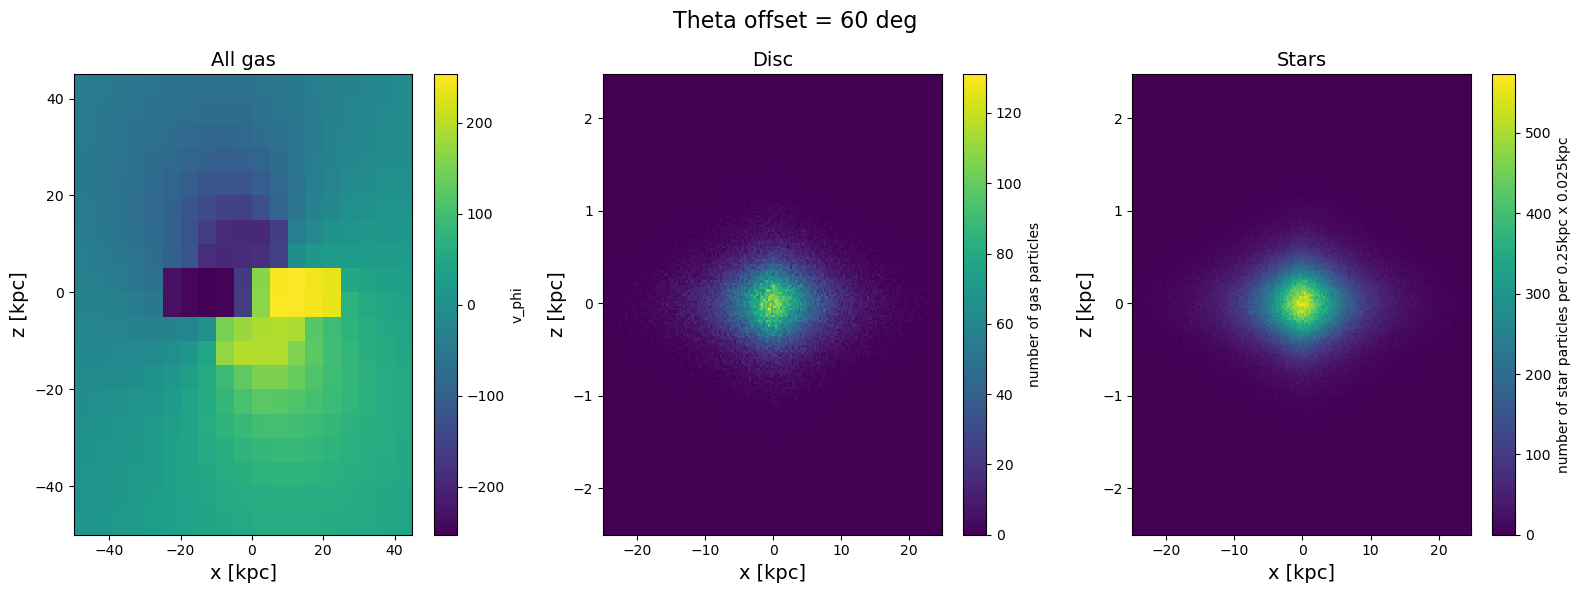

In [5]:
theta_offset=60
fiducial = ics.ICs(vc=200*un.km/un.s, #table 4 in Fraternali+11, at Rcirc
                   Rcirc=15*un.kpc, #R25 in Fraternali+18, max radius where HI is fit in non-tail side
                   Rsonic=0.1*un.kpc, #Mdot = 2  Msun/yr = SFR/2 where SFR=3.8 is from Popescu et al. (2004)
                   resolution = 8e4*un.Msun,
                    Z_CGM=0.3, #as Milky-Way
                   fgas=0.2,
                   theta_offset=np.radians(theta_offset))

fiducial.calc_CF_solution(pr=True)
ind = (fiducial.CF_solution.Rs()>20*un.kpc).nonzero()[0][0]
log_nH = log(fiducial.CF_solution.nHs()[ind].value)
print('\nlog nH(20 kpc)=%.2f, Mdot=%.3f'%(log_nH,fiducial.CF_solution.Mdot.value),'\n')

fiducial.create_output_files()

figdir = '/home/spectram/projects/AM_tel_aviv/codes/'
outputfile=figdir+'init_verification'
plot_snapshots(instance=fiducial, theta_offset=theta_offset, outputfile=outputfile)

with h5py.File(fiducial.outdirname()+'/init_snapshot.hdf5') as f:
    print(f['PartType0/Coordinates'].shape)

# verification: plot integrated 1D solution

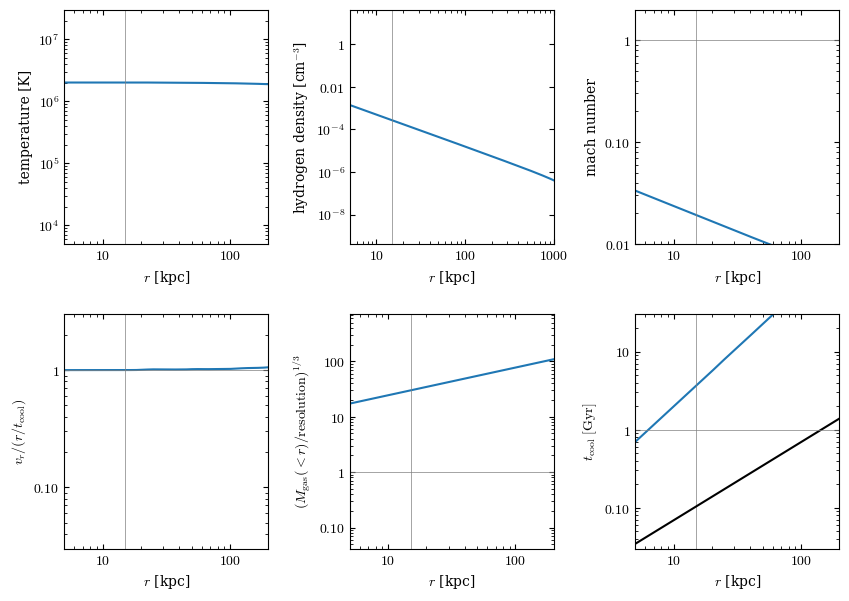

In [7]:
import matplotlib 
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rc('font', family='serif', size=10)
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['ytick.right'] = True
fig_width_half = 3.4
figdir = '/home/spectram/projects/AM_tel_aviv/codes/'
Rcirc=15*un.kpc

fig = pl.figure(figsize=(10,7))
pl.subplots_adjust(hspace=0.3,wspace=0.4)
for iPanel in range(6):
    ax = pl.subplot(2,3,iPanel+1)
    for sol in [fiducial]:
        res = sol.CF_solution
        if iPanel==0: ys = res.Ts()
        if iPanel==1: ys = res.nHs()
        if iPanel==2: ys = res.Ms()
        if iPanel==3: ys = (res.t_cools() / (res.Rs()/res.vrs())).to('')
        if iPanel==4: ys = (res.Mgas()/sol.resolution)**(1/3.)
        if iPanel==5: ys = res.t_cools() 
        pl.loglog(res.Rs(),ys)
    pl.xlim(5,200)
    pl.xlabel(r'$r$ [kpc]')
    pl.axvline(Rcirc.value,c='.5',lw=0.5)
    ax.xaxis.set_major_formatter(u.arilogformatter)
    ax.yaxis.set_major_formatter(u.arilogformatter)
    if iPanel==0:
        pl.ylabel(r'temperature [K]')
        pl.ylim(0.5e4,3e7)
    if iPanel==1: 
        pl.ylabel(r'hydrogen density [cm$^{-3}$]')
        #pl.ylim(1e-5,0.1)
        # pl.xlim(0,1000)
    if iPanel==2: 
        pl.ylabel(r'mach number')
        pl.ylim(0.01,2)
        pl.axhline(1.,c='.5',lw=0.5)
    if iPanel==3: 
        pl.ylabel(r'$v_r / (r/t_{\rm cool})$')
        pl.ylim(0.03,3)
        pl.axhline(1.,c='.5',lw=0.5)
    if iPanel==4:
        pl.ylabel(r'$(M_{\rm gas}(<r) / {\rm resolution})^{1/3}$')
#         pl.ylim(0.03,3)
        pl.axhline(1.,c='.5',lw=0.5)
    if iPanel==5: 
        pl.plot(res.Rs(),res.tff().to('Gyr'),c='k')
        pl.ylabel(r'$t_{\rm cool}\ [{\rm Gyr}]$')
        pl.ylim(0.03,30)
        pl.axhline(1.,c='.5',lw=0.5)
pl.savefig(figdir+'ICs_NGC891.pdf')

# Rough

In [6]:
def fibonacci_sphere(samples=1000):
    phi = np.linspace(0, 2 * np.pi, samples, endpoint=False)
    golden_angle = np.pi * (3 - np.sqrt(5))  # Golden angle to ensure uniform distribution

    theta = golden_angle * np.arange(samples)
    theta = np.arccos(1 - (2 * (theta / np.pi) % 2))

    #x, y, z = np.sin(theta) * np.cos(phi), np.sin(theta) * np.sin(phi), np.cos(theta)

    return phi, theta

N = 10  # Number of samples

# Generate random samples from a uniform distribution
u = np.random.random_sample(N)
v = np.random.random_sample(N)

# Transform u and v to the corresponding spherical coordinates
sampled_phis = 2 * np.pi * u
sampled_thetas = np.arccos(2 * v - 1)

print(np.degrees(sampled_phis))
print(np.degrees(sampled_thetas))

sampled_phis, sampled_thetas = fibonacci_sphere(N)

print(np.degrees(sampled_phis))
print(np.degrees(sampled_thetas))

[ 82.06656658 165.52980434  74.25156832 217.36509181   2.93155648
 163.4940781   44.94411961 159.63182128 237.5885459   70.0225394 ]
[111.25158133  57.41018704 144.71185493  83.67053536 111.87972734
 146.62533828 111.66568495  67.01675637  60.95952285 137.02592061]
[  0.  36.  72. 108. 144. 180. 216. 252. 288. 324.]
[  0.         121.86125023  93.19463937  65.39199222  27.30916949
 129.74114905  99.62414673  72.24474282  39.00530951 138.65767731]


In [7]:
# instance = instances[0]
instance = fiducial 
init_snapshot_fn = instance.outdirname()+'/init_snapshot.hdf5'
init_snapshot = h5py.File(init_snapshot_fn,'r')

In [8]:
# all gas
coords = init_snapshot['PartType0']['Coordinates']
vels = init_snapshot['PartType0']['Velocities']
inds = (coords[:,1]<5) & (coords[:,1]>-5)
Xs = coords[:,0][inds]
Zs = coords[:,2][inds]
# vals = None #for counting stars
# vals = init_snapshot['PartType0']['InternalEnergy'][inds] * (un.km**2/un.s**2 * cons.m_p / cons.k_B).to('K').value * (2./3* 0.62) 
phis = np.arctan2(vels[:,1][inds],vels[:,0][inds])

bins = (np.arange(-50,50,5),np.arange(-50,50,5))
m,x,y,_ = scipy.stats.binned_statistic_2d(Xs,
                                         Zs,
                                         vels[:,1][inds],
                                         statistic='median',
                                         bins=bins)
x = (x[1:]+x[:-1])/2; y = (y[1:]+y[:-1])/2; 

pl.pcolormesh(x,y,m.T)
pl.colorbar(label = 'v_phi')
pl.xlabel('x [kpc]'); pl.ylabel('z [kpc]')
pl.title('all gas')
# pl.savefig(KY_path+'../figures/ICs_allgas_vphi.pdf')

In [11]:
# disk only gas
snap = ics.gsr.Snapshot(instance.makedisk_filename())
coords = snap.SnapshotData['pos'][0]
energies = snap.SnapshotData['energies']
inds = (coords[:,1]<25) & (coords[:,1]>-25)
Xs = coords[:,0][inds]
Ys = coords[:,2][inds]
# vals = None #for counting stars
vals = energies[inds] * (un.km**2/un.s**2 * cons.m_p / cons.k_B).to('K').value * (2./3* 0.62) 

bins = (np.arange(-25,25,0.25),np.arange(-2.5,2.5,0.025))
m,x,y,_ = scipy.stats.binned_statistic_2d(Xs,
                                         Ys,
                                         None,
                                         statistic='count',
                                         bins=bins)
x = (x[1:]+x[:-1])/2; y = (y[1:]+y[:-1])/2; 

pl.pcolormesh(x,y,m.T)
pl.colorbar(label = 'number of gas particles')
pl.xlabel('x [kpc]'); pl.ylabel('z [kpc]')
pl.title('gas -- disk only')
#pl.savefig(KY_path+'../figures/ICs_gas_temperature.pdf')

In [14]:
coords = init_snapshot['PartType2']['Coordinates']
inds = (coords[:,1]<25) & (coords[:,1]>-25)
Xs = coords[:,0][inds]
Ys = coords[:,2][inds]

bins = (np.arange(-25,25,0.25),np.arange(-2.5,2.5,0.025))
m,x,y,_ = scipy.stats.binned_statistic_2d(Xs,
                                         Ys,
                                         None,
                                         statistic='count',
                                         bins=bins)
x = (x[1:]+x[:-1])/2; y = (y[1:]+y[:-1])/2; 
pl.pcolormesh(x,y,m.T)
pl.colorbar(label = 'number of star particles per 0.25kpc x 0.025kpc')
pl.xlabel('x [kpc]'); pl.ylabel('z [kpc]')
pl.title('stars')
#pl.savefig(KY_path+'../figures/stellar_locations.pdf')

(1e-23, 1e-22)

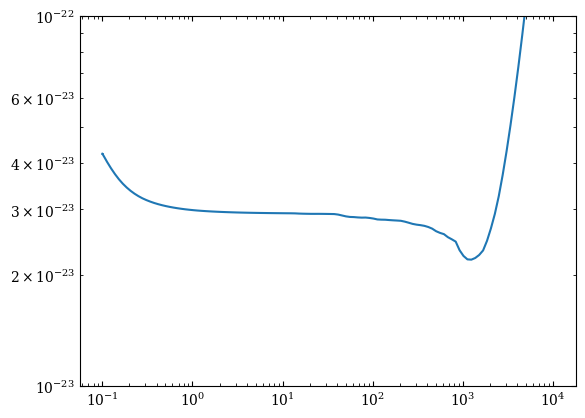

In [17]:
pl.loglog(res.Rs(), res.Lambdas())
pl.ylim(1e-23,1e-22)

# Test

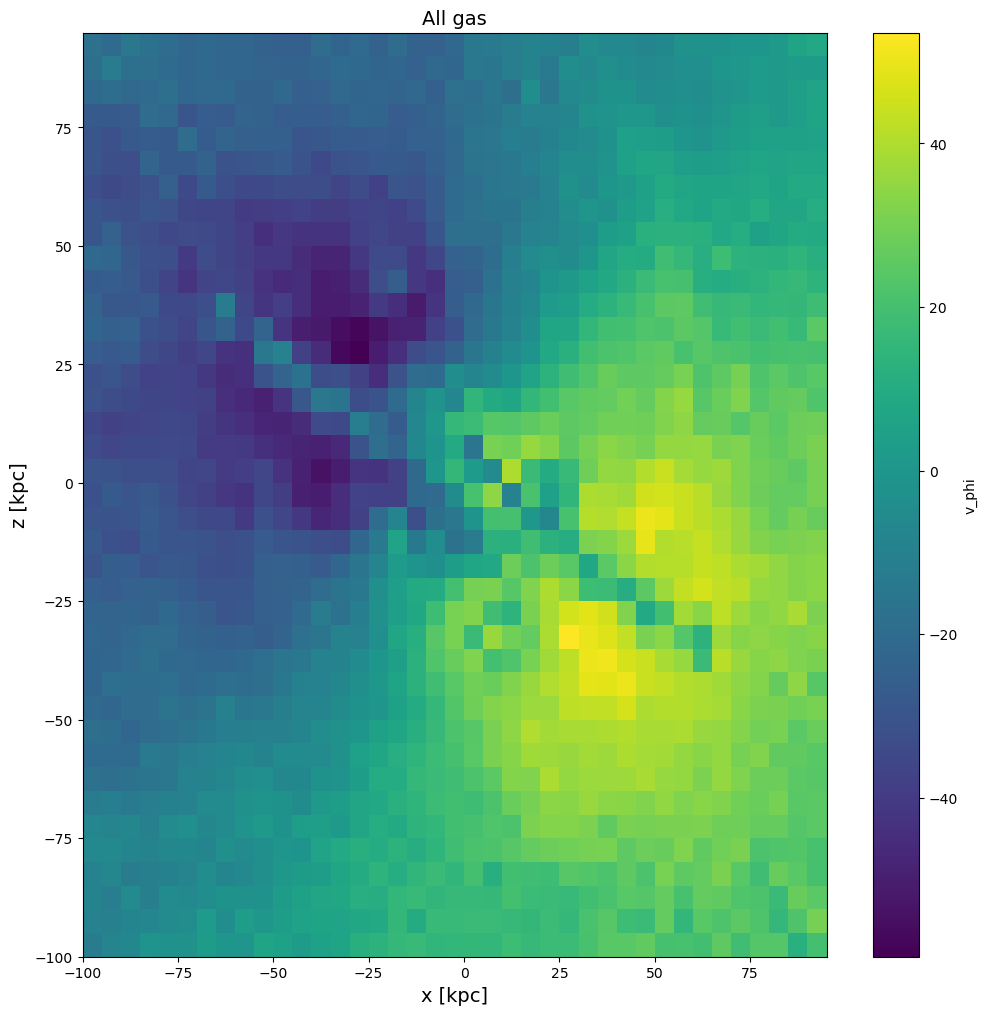

In [10]:
figdir = '/home/spectram/projects/AM_tel_aviv/codes/'
outputfile=figdir+'snap_010'
snapshot_fn=figdir+'snapshot_010.hdf5'

snapshot = h5py.File(snapshot_fn,'r')

# all gas
coords = snapshot['PartType0']['Coordinates']
vels = snapshot['PartType0']['Velocities']
inds = (coords[:,1]<25) & (coords[:,1]>-25)
Xs = coords[:,0][inds]
Zs = coords[:,2][inds]
phis = np.arctan2(vels[:,1][inds],vels[:,0][inds])

bins = (np.arange(-100,100,5),np.arange(-100,100,5))
m,x,y,_ = scipy.stats.binned_statistic_2d(Xs,
                                        Zs,
                                        vels[:,1][inds],
                                        statistic='median',
                                        bins=bins)
x = (x[1:]+x[:-1])/2; y = (y[1:]+y[:-1])/2; 

fig, axs = plt.subplots(1, 1, figsize=(12, 12))

pcm=axs.pcolormesh(x, y, m.T)
axs.set_xlabel('x [kpc]', fontsize=14)
axs.set_ylabel('z [kpc]', fontsize=14)
axs.set_title('All gas', fontsize=14)
cbar = fig.colorbar(pcm, ax=axs,label='v_phi')

In [9]:
coords.shape

(391659, 3)